# Analysis of Eurozone Past, Present, and Future Riskless rates as represented by average yields on traded AAA-rated government bonds
The first thing we need to do is construct the so-called riskless rate curve for Euro. From this curve we can then derive required forward rates. I use [the ECB's daily Euro area yield curve](https://www.ecb.europa.eu/stats/financial_markets_and_interest_rates/euro_area_yield_curves/html/index.en.html) as a proxy for riskfree rates. These rates are derived from AAA-rated government bonds of the Euro area. Ideally, using swap rates might be better as government bond yields tend to be 3-4 basis points lower given that government bonds tend to be heavily used in repo trades. See [this ECB note](https://www.ecb.europa.eu/pub/pdf/scpsps/ecb.sps27.en.pdf) for more details.

I use the following dataseries provided by the [ECB](https://data.ecb.europa.eu/data/data-categories):
* `YC.B.U2.EUR.4F.G_N_A.SV_C_YM.SR_<maturity_designator>` &mdash; Euro yield curves (daily frequency). [This series](https://data.ecb.europa.eu/data/datasets/YC?dataset%5B0%5D=Financial%20market%20data%20-%20yield%20curve%20%28YC%29&filterSequence=dataset&advFilterDataset%5B0%5D=Financial%20market%20data%20-%20yield%20curve%20%28YC%29) returns spot rates that the ECB derives from yields on AAA-rated government bonds of the Euro Area, which it calculates on every TARGET business day. The returned rates are presented using Annual percentage rates and represent the average over a given business day. [The ECB uses continuous compounding](https://www.ecb.europa.eu/stats/financial_markets_and_interest_rates/euro_area_yield_curves/shared/pdf/technical_notes.pdf) when calculating them. **NB**: In the past I obtained these data using [Eurostat](https://ec.europa.eu/eurostat/web/main/data/database), however due to delays in Eurostat updating its database, I switched to retrieving these data directly from the ECB.
* `FM.B.U2.EUR.4F.KR.DFR.LEV` &mdash; ECB Deposit Facility Rate (DFR) for Euro Area (daily frequency). I use the lower of the ECB Deposit Facility Rate and €STR as a proxy for the riskfree overnight rate.
* `EST.B.EU000A2X2A25.WT` &mdash; €STR, Euro short-term rate - Volume-weighted trimmed mean rate (daily frequency). I use the lower of €STR and the DFR as a proxy for the riskfree overnight rate.

I construct the Euro riskfree curve using 40 curve points with the following terms:
* Overnight rate from the ECB Deposit Facility Rate for Euro Area series (adjusted for the actual/actual day count convention)
* 3-, 4-, 5-, 6-, 7-, 8-, 9-, 10-, 11-months spot rate from the `irt_euryld_d` Euro yield curve series
* 1-, 2-, 3-, ..., 29-, 30-years spot rate from the `irt_euryld_d` Euro yield curve series

For constructing riskless rate curves and deriving forward rates I use the `pricing.curves.YieldCurve` class. In this class I use cubic splines by default to interpolate. See [this article](http://web.math.ku.dk/~rolf/HaganWest.pdf) for more details on interpolation methods if you want to know more. Use of cubic splines is pretty advanced.

In [1]:
# Uncomment if running in Google Colaboratory, otherwise the import of the curves module in the cell below will fail
# !git clone -l -s https://github.com/ilchen/US_Economic_Data_Analysis.git cloned-repo
# %cd cloned-repo

# Install the latest version of eurostat and sdmx
# !pip install sdmx1 -U
# !pip install eurostat -U

In [2]:
import pandas as pd
import numpy as np
import matplotlib.ticker as mtick
from pandas.tseries.offsets import BDay, MonthBegin

import eurostat
import sdmx

from datetime import date
from dateutil.relativedelta import relativedelta

from pricing import curves

In [3]:
today = date.today()

# The ECB provides yields for maturities ranging from 3 months till 30 years
month_maturities = range(3, 12)
year_maturities = range(1, 31)
maturities = [(f'SR_{maturity}M', str(maturity)+'M') for maturity in month_maturities]
maturities.extend([(f'SR_{maturity}Y', str(maturity)+'Y') for maturity in year_maturities])
maturities1, maturities2 = zip(*maturities)

ecb = sdmx.Client('ECB')
# Taking the last 100 business days, and converting to decimal fractions
data_msg = ecb.data('YC', key='B.U2.EUR.4F.G_N_A.SV_C_YM.' + '+'.join(maturities1), params={'startPeriod': (today-BDay(100)).date()})
euro_curves = sdmx.to_pandas(data_msg.data[0]).loc['B', 'U2', 'EUR', '4F', 'G_N_A', 'SV_C_YM'] / 100.
euro_curves = euro_curves.unstack(level=-2)
euro_spot_rates = euro_curves.set_axis(pd.DatetimeIndex(euro_curves.index))  #, 'B'))
euro_spot_rates = euro_spot_rates.loc[:, maturities1]
euro_spot_rates.columns = maturities2

# Taking the last 5 business days, and converting to decimal fractions
# Retrieving the most recent ECB Deposit Facility Rate, and converting to decimal fractions
data_msg = ecb.data('FM', key='B.U2.EUR.4F.KR.DFR.LEV', params={'startPeriod': today-relativedelta(years=2)})
ecb_deposit_rate = sdmx.to_pandas(data_msg.data[0]).loc['B', 'U2', 'EUR', '4F', 'KR', 'DFR', 'LEV'] / 100.
ecb_deposit_rate = ecb_deposit_rate.set_axis(pd.DatetimeIndex(ecb_deposit_rate.index))

# The ECB only posts updates on dates when a new rate is effective, hence I forward fill them for all relevant business days.
ecb_deposit_rate = pd.concat([ecb_deposit_rate, pd.Series(index=euro_spot_rates.index.difference(ecb_deposit_rate.index))])
ecb_deposit_rate = ecb_deposit_rate.ffill().loc[euro_spot_rates.index[0]:]

# The €STR rate
data_msg = ecb.data('EST', key='B.EU000A2X2A25.WT', params={'startPeriod': today-relativedelta(years=2)})
overnight_rate = sdmx.to_pandas(data_msg.data[0]).loc['B', 'EU000A2X2A25', 'WT'] / 100.
overnight_rate = overnight_rate.set_axis(pd.DatetimeIndex(overnight_rate.index)).loc[euro_spot_rates.index[0]:]
if not overnight_rate.index.difference(ecb_deposit_rate.index).empty:
    overnight_rate = overnight_rate.loc[ecb_deposit_rate.index]

# Using a minimum of the €STR and DFR rates
overnight_rate = pd.concat([overnight_rate, ecb_deposit_rate], axis=1).min(axis=1)

In [4]:
# Converting the overnight rates from actual/360 to actual/actual and then to a continuous compounding frequency
leap_year_cond = lambda idx: idx.year % 4 == 0 & ((idx.year % 100 != 0) | (idx.year % 400 == 0))
overnight_rate[leap_year_cond(overnight_rate.index)] *= 366. / 360
overnight_rate[np.invert(leap_year_cond(overnight_rate.index))] *= 365. / 360

# From annual to continuous compounding
overnight_rate = np.log(1 + overnight_rate)

In [5]:
date_now = euro_spot_rates.index[-1].date()

delta = relativedelta(weeks=+1)
delta = relativedelta(months=+1)
# delta = relativedelta(months=+2)
# delta = relativedelta(months=+3)

past_label = 'one week prior'
past_label = 'one month prior'
# past_label = 'two months prior'
# past_label = 'three months prior'

# Ensuring we go back to the last business of the chosen time interval
past_date = BDay(0).rollback(date_now - delta)
# A small adjustiment in case Euro Area government bonds were not trading on a business day 1 week ago
past_date = euro_spot_rates.index.where(euro_spot_rates.index <= past_date).dropna()[-1]

offsets = [relativedelta(months=+maturity) for maturity in month_maturities]
offsets.extend([relativedelta(years=+maturity) for maturity in year_maturities])
offsets = [relativedelta()] + offsets

In [6]:
# Define the riskless yield curve for Euro
curve = curves.YieldCurve(date_now, offsets,
        np.append(
            overnight_rate.iloc[-1],
            euro_spot_rates.iloc[-1].to_numpy()),
        compounding_freq=0)

past_curve = curves.YieldCurve(date_now, offsets,
        np.append(
            overnight_rate.loc[past_date],
            euro_spot_rates.loc[past_date,:].to_numpy()),
        compounding_freq=0)

In [7]:
curve_points = curve.get_curve_points(120)
curve_points_past = past_curve.get_curve_points(120)
curve_points.rename('Euro riskless rate', inplace=True)
curve_points_past.rename(curve_points.name + f' ({past_label})', inplace=True)

# Replacing indices for sake of better visualization
df = pd.concat([curve_points, curve_points_past.set_axis(curve_points.index)], axis=1)

#### Compounding frequency
The rates presented throughout this notebook use a continuous compounding frequency.

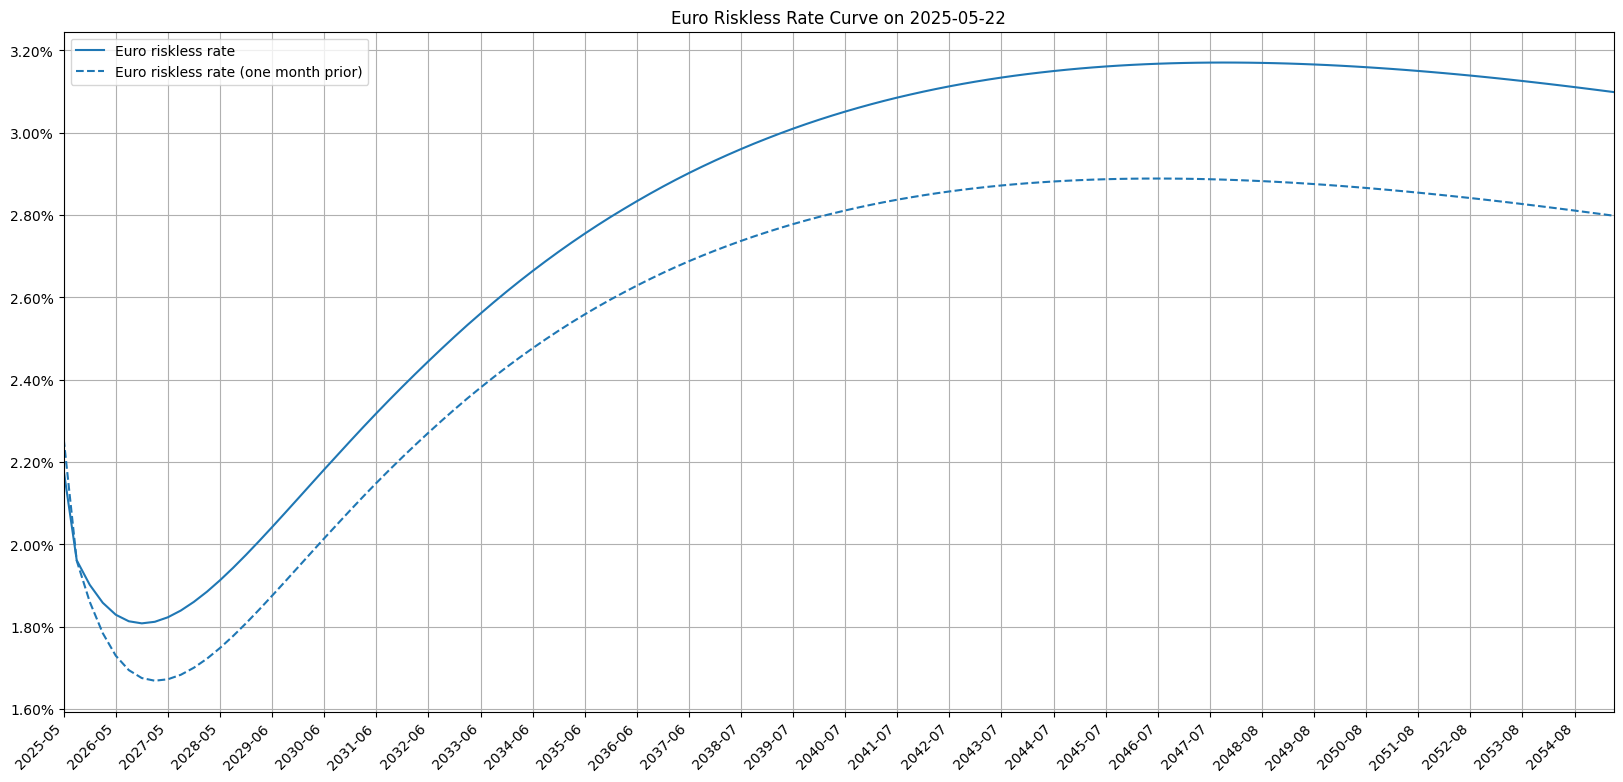

In [8]:
ax = df.iloc[:,:1].plot(figsize=(20,10), grid=True,
                        title='Euro Riskless Rate Curve on ' + date_now.strftime('%Y-%m-%d'),
                        xlim=(curve_points.index[0], curve_points.index[-1]),
                        xticks=curve_points.index[::4], xlabel='', rot=45)
df.iloc[:,1:].plot(ax=ax, grid=True, xticks=df.index[::4], rot=45, linestyle='--', color=['#1f77b4', '#ff7f0e'])
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
_ = ax.set_xticklabels(list(map(lambda x: x.strftime('%Y-%m'), curve_points.index[::4])))

In [9]:
print('The curve on {:%Y-%m-%d} changed by an average of {:+.2f}bps compared to {:s}'
      .format(euro_spot_rates.index[-1].date(), 10000 * (df.iloc[:,0].mean() - df.iloc[:,1].mean()), past_label))

The curve on 2025-05-22 changed by an average of +22.65bps compared to one month prior


In [10]:
offset_in_years = 3

In [11]:
print('Average short-term (<{:d}y) riskless yield: {:.2%}'.format(offset_in_years,
    curve_points.loc[:(euro_spot_rates.index[-1].date()+relativedelta(years=+offset_in_years))].mean()))

Average short-term (<3y) riskless yield: 1.88%


In [12]:
print('Average long-term (>{:d}y) riskless yield: {:.2%}'.format(offset_in_years,
    curve_points.loc[(euro_spot_rates.index[-1].date()+relativedelta(years=+offset_in_years)):].mean()))

Average long-term (>3y) riskless yield: 2.89%


In [13]:
print('Long-term (>{:d}y) riskless yield: {:.2%}-{:.2%}'.format(offset_in_years,
    curve_points.loc[(euro_spot_rates.index[-1].date()+relativedelta(years=+offset_in_years)):].min(),
    curve_points.loc[(euro_spot_rates.index[-1].date()+relativedelta(years=+offset_in_years)):].max()))
print('Compared to: {:.2%}-{:.2%} {:s}'.format(
    curve_points_past.loc[(euro_spot_rates.index[-1].date()+relativedelta(years=+offset_in_years)):].min(),
    curve_points_past.loc[(euro_spot_rates.index[-1].date()+relativedelta(years=+offset_in_years)):].max(),
    past_label))

Long-term (>3y) riskless yield: 1.91%-3.17%
Compared to: 1.75%-2.89% one month prior


## Past, Present, and Future Eurozone Riskless rates
In this section of the notebook I calculate the past, present, and future 1-year, 2-year, 3-year, and 5-year riskless rates. As future riskless rates I use forward rates derived from the most recent riskless rates curve (see the graph above). The presented rates use continuous compounding frequencies

### Retrieving riskless rates for the past months

In [14]:
start_date = date(2022, 1, 1)

# The ECB provides yields for maturities ranging from 1 till 30 years
year_maturities = range(1, 6)
maturities = [('Y'+str(maturity), str(maturity)+'Y') for maturity in year_maturities]
maturities_key, maturities = zip(*maturities)
maturities_past = list(map(lambda s: s + f' {past_label}', maturities))
maturities = list(maturities)

# Taking all the months starting on 'start_date' and converting to decimal fractions
euro_riskless_rates = eurostat.get_data_df('irt_euryld_m', filter_pars={
    'startPeriod': start_date, 'freq': 'M',
    'yld_curv': 'SPOT_RT',
    'maturity': list(maturities_key),
    'bonds': 'CGB_EA_AAA', 'geo': 'EA'})
euro_riskless_rates = euro_riskless_rates.drop(euro_riskless_rates.columns[:3].append(
    euro_riskless_rates.columns[4:5]), axis=1)
euro_riskless_rates = euro_riskless_rates.set_index(euro_riskless_rates.columns[0]).T / 100.
euro_riskless_rates = euro_riskless_rates.set_axis(pd.DatetimeIndex(euro_riskless_rates.index, 'MS'))
euro_riskless_rates.columns = maturities

### Extending for future months using forward rates
I use the curve constructed from the most recent data that I created in the begining of this notebook to produce forward rates.

In [15]:
# Eurostat is sometimes late with updating data for the last month
euro_spot_rates_monthly = euro_spot_rates.resample('MS').mean().loc[:date_now - MonthBegin(2)]
idx = euro_spot_rates_monthly.index.difference(euro_riskless_rates.index)
if not idx.empty:
    euro_riskless_rates = pd.concat([euro_riskless_rates, euro_spot_rates_monthly.loc[idx,maturities]])

# Finally, let's add the most recent spot rates for the current month
euro_riskless_rates = pd.concat([
    euro_riskless_rates, euro_spot_rates.loc[MonthBegin(0).rollback(date_now):,maturities].resample('MS').last()])

In [16]:
# Now let's extend with forward rates for the coming months
num_future_months = 17

# Calculating forward treasury yields from the earlier constructed Treasury Yield Curves
terms = [relativedelta(years=+maturity) for maturity in year_maturities]

idx_future_dates = pd.date_range(euro_riskless_rates.index[-1].date()+relativedelta(months=+1),
                                 periods=num_future_months-1, freq='MS')

In [17]:
def to_forward_yield(forward_date, term, fn):
    return fn(forward_date, forward_date + term)[0]

from functools import partial

fwd_riskless_rates = [idx_future_dates.to_series().apply(
    partial(to_forward_yield, term=term, fn=curve.get_forward_yield_for_maturity_date)) for term in terms]
fwd_riskless_rates = pd.DataFrame(fwd_riskless_rates, index=maturities).T

fwd_riskless_rates_past = [idx_future_dates.to_series().apply(
    partial(to_forward_yield, term=term, fn=past_curve.get_forward_yield_for_maturity_date)) for term in terms]
fwd_riskless_rates_past = pd.DataFrame(fwd_riskless_rates_past, index=maturities).T

In [18]:
fwd_riskless_rates_past = pd.concat([euro_riskless_rates.iloc[-1:], fwd_riskless_rates_past])
fwd_riskless_rates_past.columns = maturities_past
euro_riskless_rates = pd.concat([euro_riskless_rates, fwd_riskless_rates])

### Visualizing Risklss Rates for different maturities

#### 1, 3, and 5 Year Riskless Rates in one graph
Please remove the comments if you'd like to see changes from the previous week.

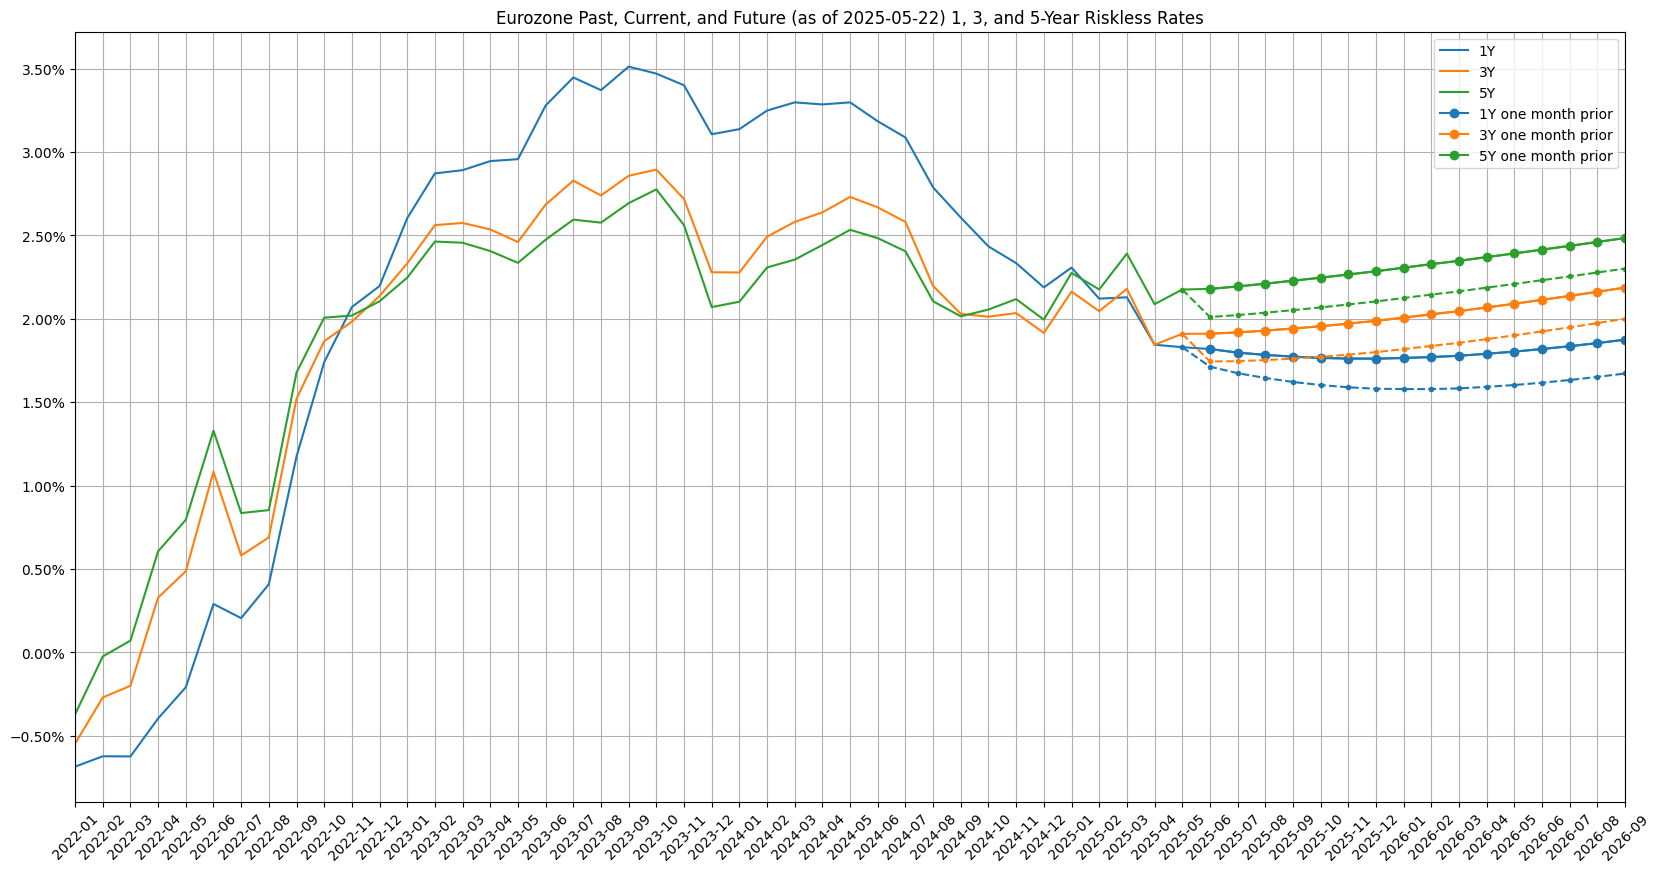

In [19]:
maturiries_selection = maturities[::2]
maturiries_selection_past = maturities_past[::2]
ax = euro_riskless_rates.loc[:,maturiries_selection].plot(figsize=(20,10), grid=True,
                 title='Eurozone Past, Current, and Future (as of {:%Y-%m-%d}) 1, 3, and 5-Year Riskless Rates'
                                          .format(euro_spot_rates.index[-1].date()),
                 xticks=euro_riskless_rates.index, xlabel='', rot=45)
fwd_riskless_rates.loc[:,maturiries_selection].plot(ax=ax, grid=True, marker='o',
                                                    xticks=euro_riskless_rates.index, xlabel='',
                                                    yticks=np.arange(-.005, .04, 0.005),
                                                    rot=45, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
fwd_riskless_rates_past.loc[:,maturiries_selection_past].plot(
    ax=ax, grid=True, marker='.', linestyle='--', xticks=euro_riskless_rates.index, xlabel='',
    rot=45, color=['#1f77b4','#ff7f0e', '#2ca02c'])
ax.legend(maturiries_selection)
ax.legend(maturiries_selection + maturiries_selection_past)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, euro_riskless_rates.index)))

#### 1 Year Riskless Rates

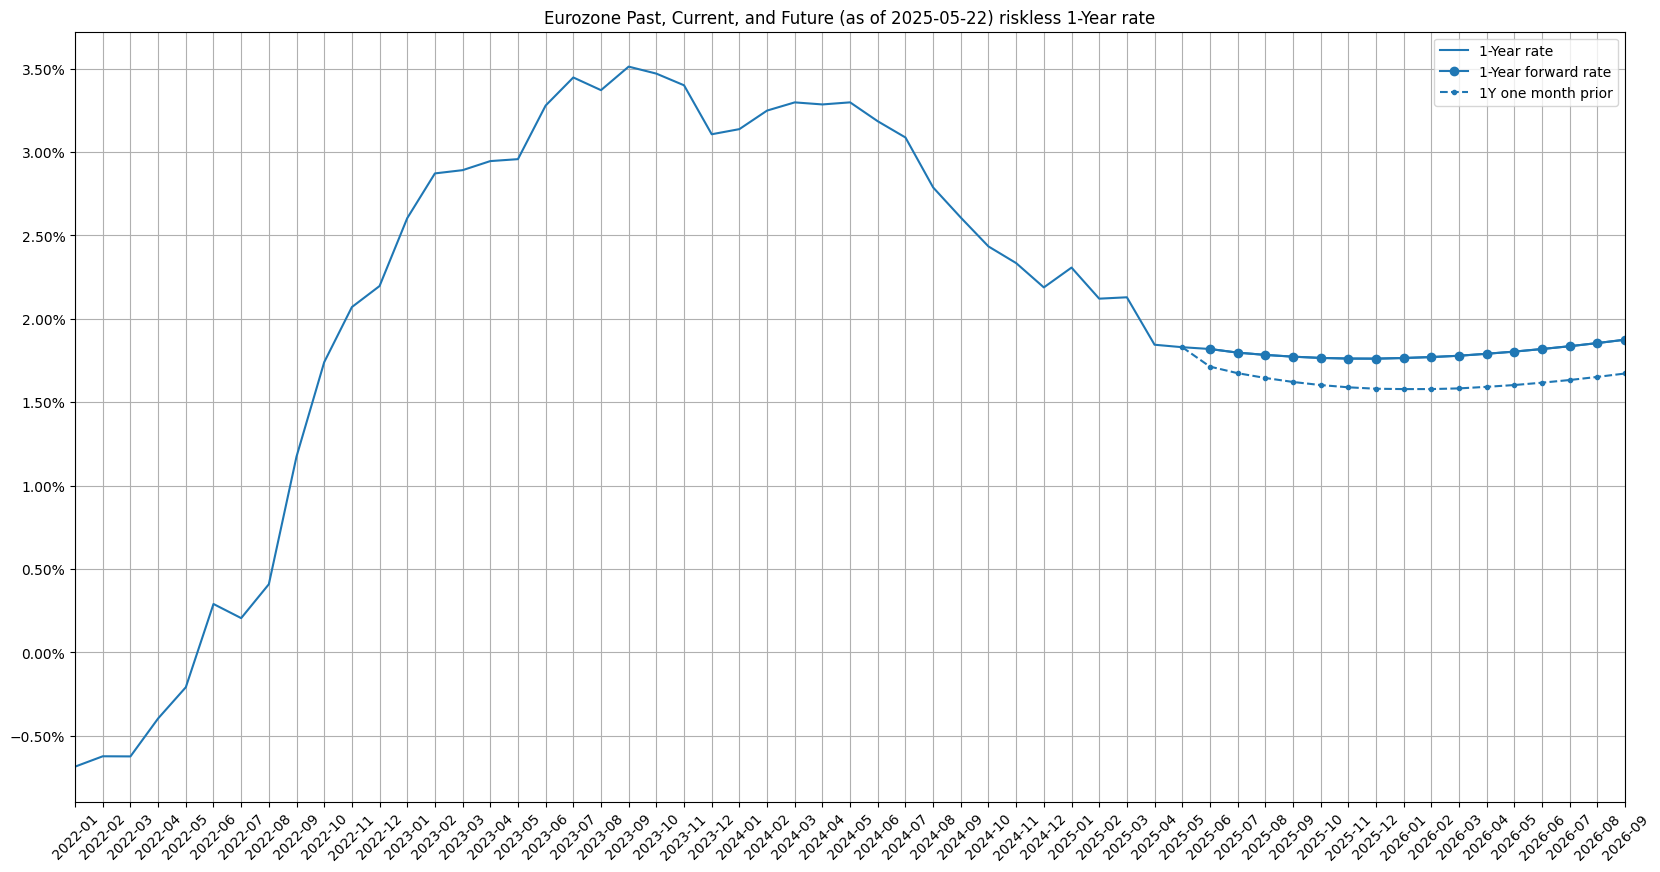

In [20]:
ax = euro_riskless_rates.loc[:,'1Y'].rename('1-Year rate').plot(figsize=(20,10), grid=True,
                 title='Eurozone Past, Current, and Future (as of {:%Y-%m-%d}) riskless 1-Year rate'
                                          .format(euro_spot_rates.index[-1].date()),
                 xticks=euro_riskless_rates.index, xlabel='', rot=45)
fwd_riskless_rates.loc[:,'1Y'].rename('1-Year forward rate').plot(ax=ax, grid=True, marker='o',
                                                                  xticks=euro_riskless_rates.index, xlabel='',
                                                                  yticks=np.arange(-.005, .04, 0.005),
                                                                  rot=45, color='#1f77b4')
fwd_riskless_rates_past.iloc[:,0].plot(ax=ax, grid=True, marker='.', linestyle='--',
                                       xticks=euro_riskless_rates.index, xlabel='',
                                       yticks=np.arange(-.005, .04, 0.005), rot=45, color='#1f77b4')
ax.legend()
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, euro_riskless_rates.index)))

#### 2 Year Riskless Rates

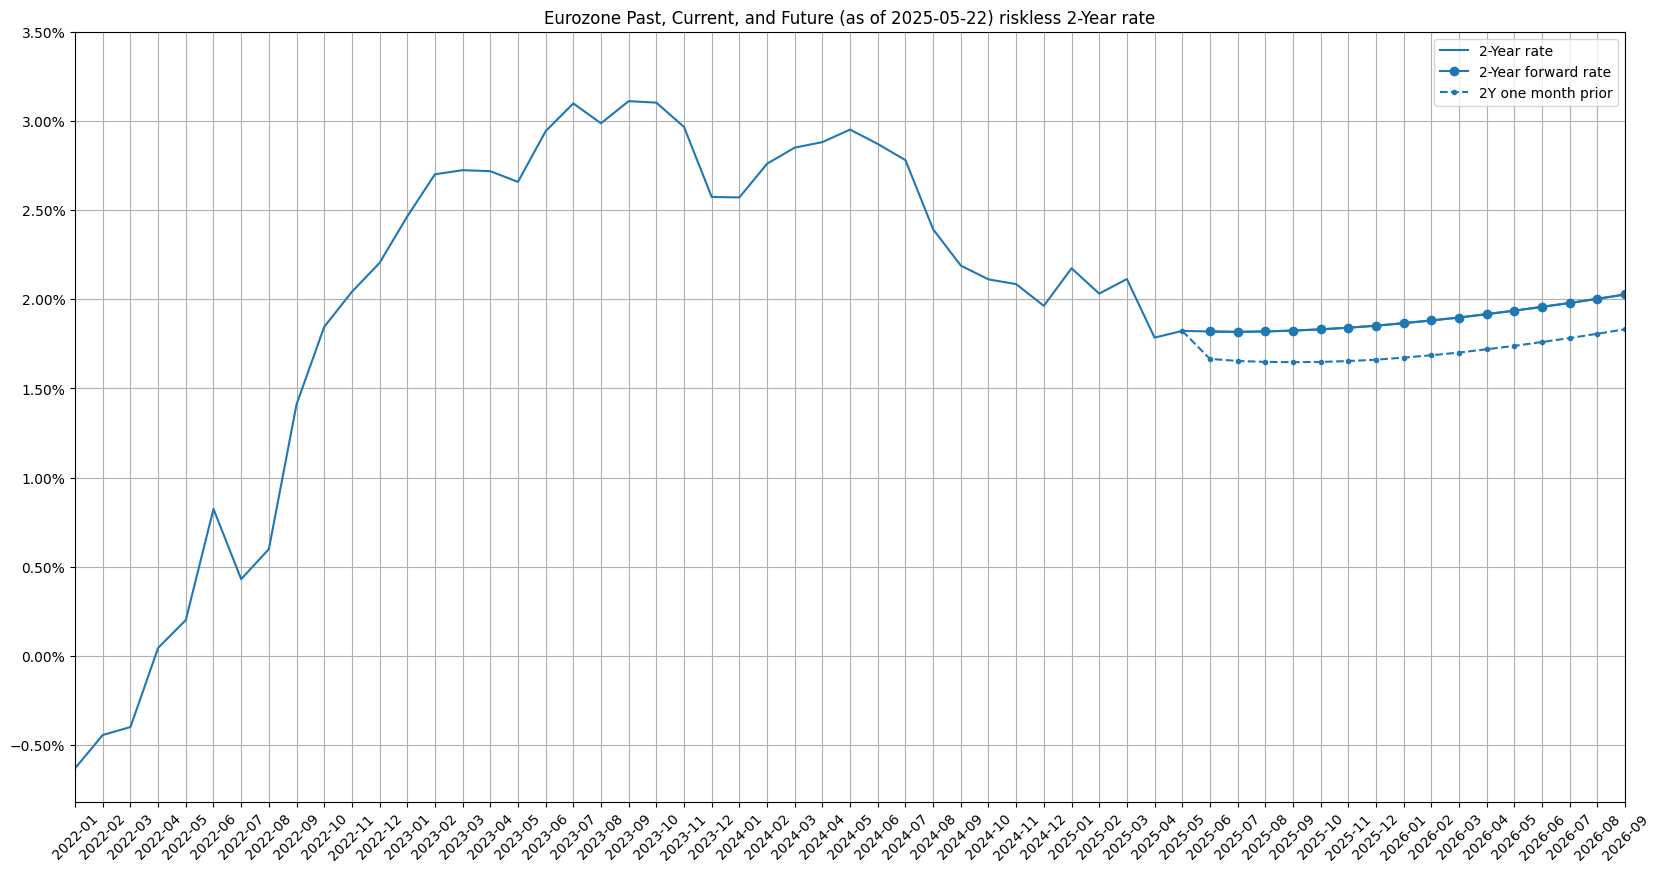

In [21]:
ax = euro_riskless_rates.loc[:,'2Y'].rename('2-Year rate').plot(figsize=(20,10), grid=True,
                 title='Eurozone Past, Current, and Future (as of {:%Y-%m-%d}) riskless 2-Year rate'
                                          .format(euro_spot_rates.index[-1].date()),
                 xticks=euro_riskless_rates.index, xlabel='', rot=45)
fwd_riskless_rates.loc[:,'2Y'].rename('2-Year forward rate').plot(ax=ax, grid=True, marker='o',
                                                                  xticks=euro_riskless_rates.index, xlabel='',
                                                                  rot=45, color='#1f77b4')
fwd_riskless_rates_past.iloc[:,1].plot(ax=ax, grid=True, marker='.', linestyle='--',
                                       xticks=euro_riskless_rates.index, xlabel='',
                                       yticks=np.arange(-.005, .04, 0.005), rot=45, color='#1f77b4')
ax.legend()
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, euro_riskless_rates.index)))

#### 3 Year Riskless Rate

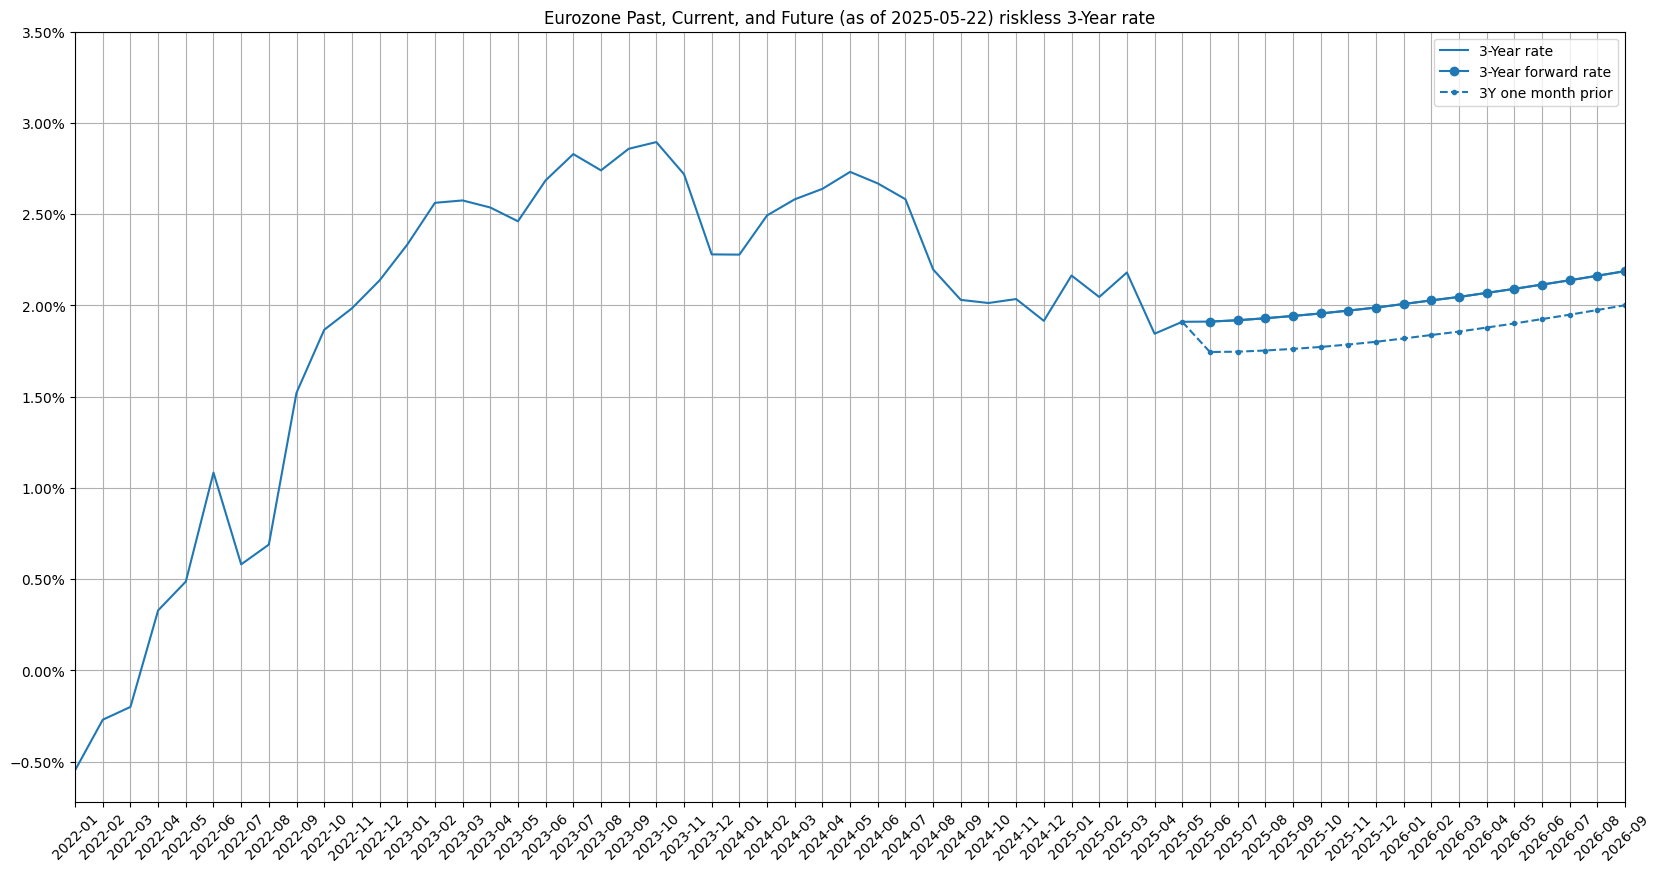

In [22]:
ax = euro_riskless_rates.loc[:,'3Y'].rename('3-Year rate').plot(figsize=(20,10), grid=True,
                 title='Eurozone Past, Current, and Future (as of {:%Y-%m-%d}) riskless 3-Year rate'
                                          .format(euro_spot_rates.index[-1].date()),
                 xticks=euro_riskless_rates.index, xlabel='', rot=45)
fwd_riskless_rates.loc[:,'3Y'].rename('3-Year forward rate').plot(ax=ax, grid=True, marker='o',
                                                                  xticks=euro_riskless_rates.index, xlabel='',
                                                                  rot=45, color='#1f77b4')
fwd_riskless_rates_past.iloc[:,2].plot(ax=ax, grid=True, marker='.', linestyle='--',
                                       xticks=euro_riskless_rates.index, xlabel='',
                                       yticks=np.arange(-.005, .04, 0.005), rot=45, color='#1f77b4')
ax.legend()
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, euro_riskless_rates.index)))

#### 5 Year Riskless Rate

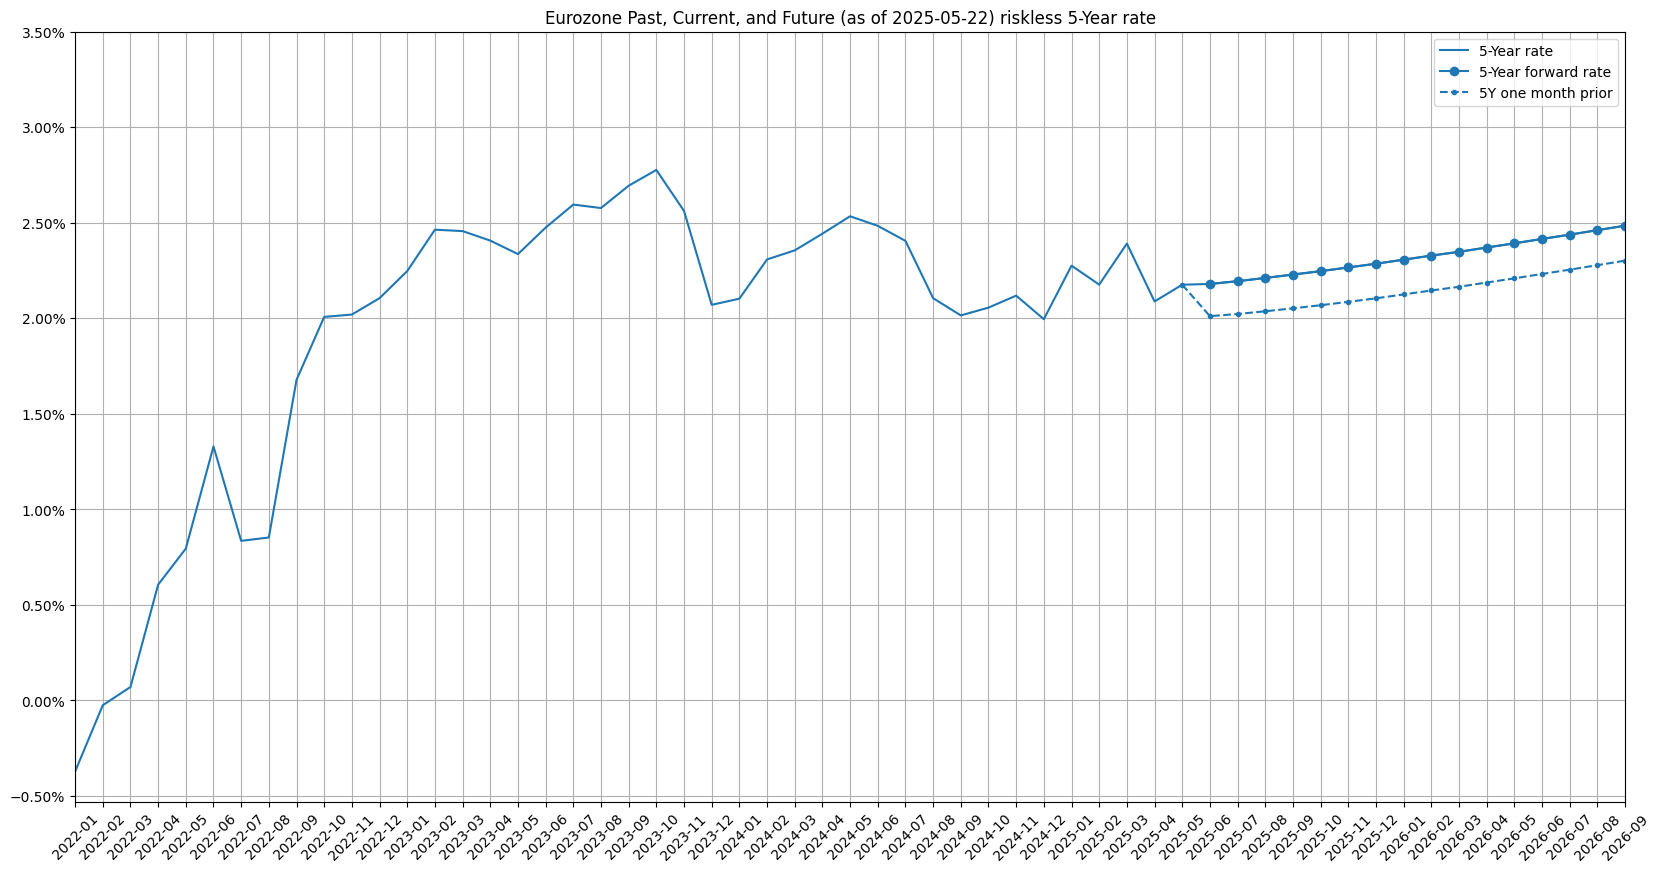

In [23]:
ax = euro_riskless_rates.loc[:,'5Y'].rename('5-Year rate').plot(figsize=(20,10), grid=True,
                 title='Eurozone Past, Current, and Future (as of {:%Y-%m-%d}) riskless 5-Year rate'
                                          .format(euro_spot_rates.index[-1].date()),
                 xticks=euro_riskless_rates.index, xlabel='', rot=45)
fwd_riskless_rates.loc[:,'5Y'].rename('5-Year forward rate').plot(ax=ax, grid=True, marker='o',
                                                                  xticks=euro_riskless_rates.index, xlabel='',
                                                                  rot=45, color='#1f77b4')
fwd_riskless_rates_past.iloc[:,4].plot(ax=ax, grid=True, marker='.', linestyle='--',
                                       xticks=euro_riskless_rates.index, xlabel='',
                                       yticks=np.arange(-.005, .04, 0.005), rot=45, color='#1f77b4')
ax.legend()
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, euro_riskless_rates.index)))

#### Forward riskless rates changes compared to the previous date

In [24]:
print(f'Percentage point changes in forward riskless rates compared to {past_label}:')
fwd_riskless_rates_past.columns=fwd_riskless_rates.columns
((fwd_riskless_rates-fwd_riskless_rates_past)*100).dropna()

Percentage point changes in forward riskless rates compared to one month prior:


,1Y,2Y,3Y,4Y,5Y
2025-06-01,0.105582,0.153739,0.166620,0.168295,0.168494
2025-07-01,0.123212,0.162927,0.172188,0.172214,0.171709
2025-08-01,0.138382,0.170649,0.176743,0.175397,0.174357
2025-09-01,0.151685,0.177228,0.180526,0.178036,0.176587
2025-10-01,0.162751,0.182527,0.183474,0.180089,0.178361
2025-11-01,0.172440,0.186994,0.185854,0.181744,0.179839
2025-12-01,0.180466,0.190537,0.187650,0.182998,0.181008
2026-01-01,0.186443,0.192954,0.188740,0.183745,0.181789
2026-02-01,0.192019,0.195102,0.189631,0.184384,0.182503
2026-03-01,0.195816,0.196427,0.190018,0.184674,0.182931


In [25]:
print(f'They changed by {(fwd_riskless_rates-fwd_riskless_rates_past).min().min():.3%} - '
      f'{(fwd_riskless_rates-fwd_riskless_rates_past).max().max():.3%}')

They changed by 0.106% - 0.203%


In [26]:
print(f'Forward riskless rates in {fwd_riskless_rates.index[-1].date()}:')
fwd_riskless_rates.iloc[-1:]

Forward riskless rates in 2026-09-01:


,1Y,2Y,3Y,4Y,5Y
2026-09-01,0.01875,0.020264,0.021875,0.023427,0.024846


In [27]:
print(f'Percentage point changes in forward riskless rates for {fwd_riskless_rates.index[-1].date()} '
      f'compared to {MonthBegin().rollback(past_date).date()}:')
fwd_riskless_rates.iloc[-1:] - fwd_riskless_rates_past.iloc[-1:]

Percentage point changes in forward riskless rates for 2026-09-01 compared to 2025-04-01:


,1Y,2Y,3Y,4Y,5Y
2026-09-01,0.002028,0.001949,0.001868,0.001828,0.00183


#### Actual riskless rates changes compared to the previous date

In [28]:
print(f'Percentage point changes in actual riskless rates compared to {MonthBegin().rollback(past_date).date()}:')
((euro_riskless_rates.loc[MonthBegin().rollback(date_now)] - euro_riskless_rates.loc[MonthBegin().rollback(past_date)])*100)\
    .to_frame(name=MonthBegin().rollback(date_now)).T

Percentage point changes in actual riskless rates compared to 2025-04-01:


,1Y,2Y,3Y,4Y,5Y
2025-05-01,-0.014826,0.037528,0.065467,0.079917,0.08751
